# Prediction Results Analysis

This notebook loads and visualizes the results from our prediction pipeline.

Please make sure to run the pipeline first.

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json

plt.style.use('classic')
sns.set_palette('husl')
sns.set_theme()

In [11]:
# NOTE: if you run your own pipeline, please update the timestamp below. 
# By default using saved results.
RESULTS_DIR = 'results/20241029_204138'

# Load config
with open(Path(RESULTS_DIR) / 'config.json') as f:
    config = json.load(f)

# Load metrics
metrics_df = pd.read_csv(Path(RESULTS_DIR) / 'metrics.csv')

# Load predictions for new drug-disease pairs, if they exist
try:
    predictions_df = pd.read_csv(Path(RESULTS_DIR) / 'predictions.csv')
    has_predictions = True
except FileNotFoundError:
    has_predictions = False

## 1. Model Performance Metrics Overview

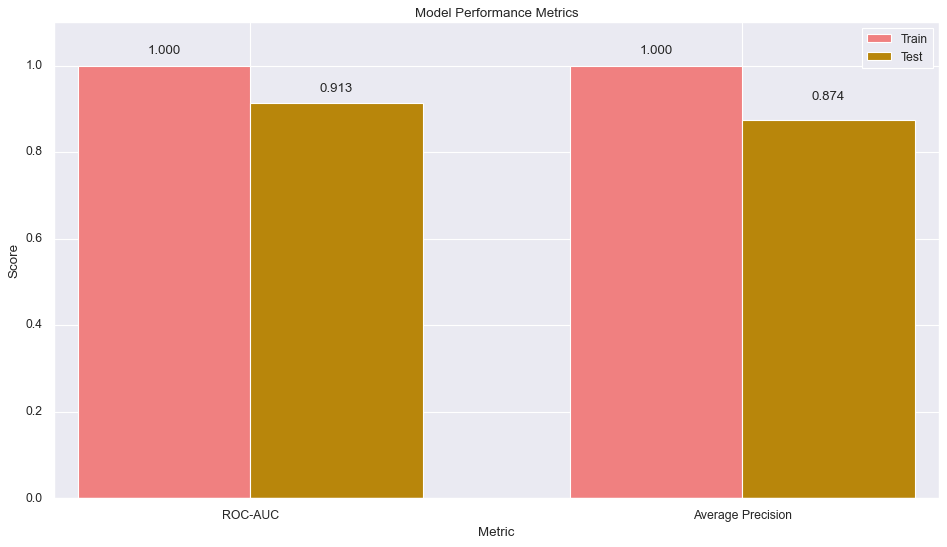

In [12]:
# Create a bar plot comparing train and test metrics
sns.set_theme()
plt.figure(figsize=(12, 7))
x = np.arange(len(metrics_df['metric']))
width = 0.35

# Create bars
plt.bar(x - width/2, metrics_df['train'], width, label='Train', color='lightcoral')
plt.bar(x + width/2, metrics_df['test'], width, label='Test', color='darkgoldenrod')

plt.xlabel('Metric')
plt.ylabel('Score')
plt.title('Model Performance Metrics')
plt.xticks(x, metrics_df['metric'])
plt.legend()

# Add value labels on top of bars with adjusted positioning
for i, v in enumerate(metrics_df['train']):
    # Position train labels slightly higher
    plt.text(i - width/2, v + 0.02, f'{v:.3f}', 
             ha='center',
             va='bottom')
    
for i, v in enumerate(metrics_df['test']):
    # Position test labels even higher for the second metric
    y_offset = 0.02 if i == 0 else 0.04  # Larger offset for Average Precision
    plt.text(i + width/2, v + y_offset, f'{v:.3f}', 
             ha='center',
             va='bottom')

# Adjust y-axis limit to make room for labels
plt.ylim(0, 1.1)  # Increased upper limit to accommodate labels

plt.tight_layout()
plt.show()

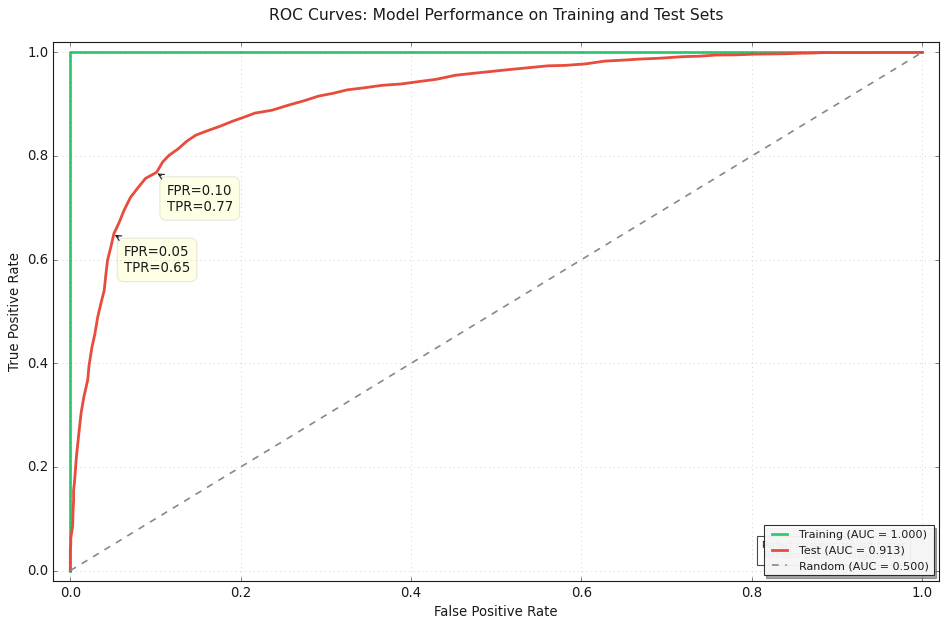


Model Performance Metrics:
-------------------------
Training ROC-AUC: 1.000
Test ROC-AUC:     0.913
Difference:       0.087

Test Set Performance at Different Operating Points:
------------------------------------------------
At   1% FPR: TPR = 0.275
At   5% FPR: TPR = 0.650
At  10% FPR: TPR = 0.769


In [4]:
def load_and_plot_roc_curves(results_dir: str):
    """
    Load and plot ROC curves from saved results with improved clarity
    
    Parameters:
    -----------
    results_dir: str
        Path to the results directory containing roc_curves.npz and metrics.csv
    """
    sns.set_theme()
    # Load ROC curve data
    roc_data = np.load(Path(results_dir) / 'roc_curves.npz')
    metrics_df = pd.read_csv(Path(results_dir) / 'metrics.csv')
    
    # Get ROC-AUC scores
    train_auc = metrics_df[metrics_df['metric'] == 'ROC-AUC']['train'].iloc[0]
    test_auc = metrics_df[metrics_df['metric'] == 'ROC-AUC']['test'].iloc[0]
    
    # Create figure with a larger size
    plt.figure(figsize=(12, 8))
    
    # Set style
    plt.style.use('classic')
    
    # Plot training ROC
    plt.plot(roc_data['train_fpr'], 
             roc_data['train_tpr'],
             label=f'Training (AUC = {train_auc:.3f})',
             color='#2ecc71',  # Green
             linewidth=2.5)
    
    # Plot test ROC
    plt.plot(roc_data['test_fpr'],
             roc_data['test_tpr'],
             label=f'Test (AUC = {test_auc:.3f})',
             color='#e74c3c',  # Red
             linewidth=2.5)
    
    # Plot random classifier line
    plt.plot([0, 1], [0, 1],
             color='#7f8c8d',  # Gray
             linestyle='--',
             linewidth=1.5,
             label='Random (AUC = 0.500)')
    
    # Customize plot
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('ROC Curves: Model Performance on Training and Test Sets', 
              fontsize=14, pad=20)
    
    # Add grid with lower opacity
    plt.grid(True, alpha=0.3)
    
    # Set axis limits
    plt.xlim(-0.02, 1.02)
    plt.ylim(-0.02, 1.02)
    
    # Add legend with shadow and larger font
    plt.legend(loc='lower right', 
              fontsize=10, 
              framealpha=0.9, 
              shadow=True)
    
    # Add annotations for key points
    test_points = {
        0.05: roc_data['test_tpr'][np.argmin(np.abs(roc_data['test_fpr'] - 0.05))],
        0.1: roc_data['test_tpr'][np.argmin(np.abs(roc_data['test_fpr'] - 0.1))]
    }
    
    for fpr, tpr in test_points.items():
        plt.annotate(f'FPR={fpr:.2f}\nTPR={tpr:.2f}',
                    xy=(fpr, tpr),
                    xytext=(10, -10),
                    textcoords='offset points',
                    ha='left',
                    va='top',
                    bbox=dict(boxstyle='round,pad=0.5', 
                            fc='yellow', 
                            alpha=0.1),
                    arrowprops=dict(arrowstyle='->'))
    
    # Add descriptive text
    plt.text(0.98, 0.02, 
             'Perfect classifier: top-left corner\nRandom classifier: diagonal line', 
             ha='right', 
             va='bottom',
             fontsize=8,
             bbox=dict(facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed metrics
    print("\nModel Performance Metrics:")
    print("-------------------------")
    print(f"Training ROC-AUC: {train_auc:.3f}")
    print(f"Test ROC-AUC:     {test_auc:.3f}")
    print(f"Difference:       {(train_auc - test_auc):.3f}")
    
    # Calculate and display specific operating points
    def get_metrics_at_fpr(fpr_target, fpr, tpr):
        idx = np.argmin(np.abs(fpr - fpr_target))
        return {'fpr': fpr[idx], 'tpr': tpr[idx]}
    
    print("\nTest Set Performance at Different Operating Points:")
    print("------------------------------------------------")
    for target_fpr in [0.01, 0.05, 0.1]:
        metrics = get_metrics_at_fpr(target_fpr, 
                                   roc_data['test_fpr'], 
                                   roc_data['test_tpr'])
        print(f"At {target_fpr*100:>3.0f}% FPR: TPR = {metrics['tpr']:.3f}")


load_and_plot_roc_curves(RESULTS_DIR)

### Observations: 
The training results suggest some overfitting, however the performance on test set is still not bad.

When TPR at 10% the FPR is at 77% - so we can identify majority of true relationships while maintaining a reasonable FPR. It will depend on the tolerance for false positives in our application, but just based on the elbow in the graph would suggest a threshold around 5-10% FPR.

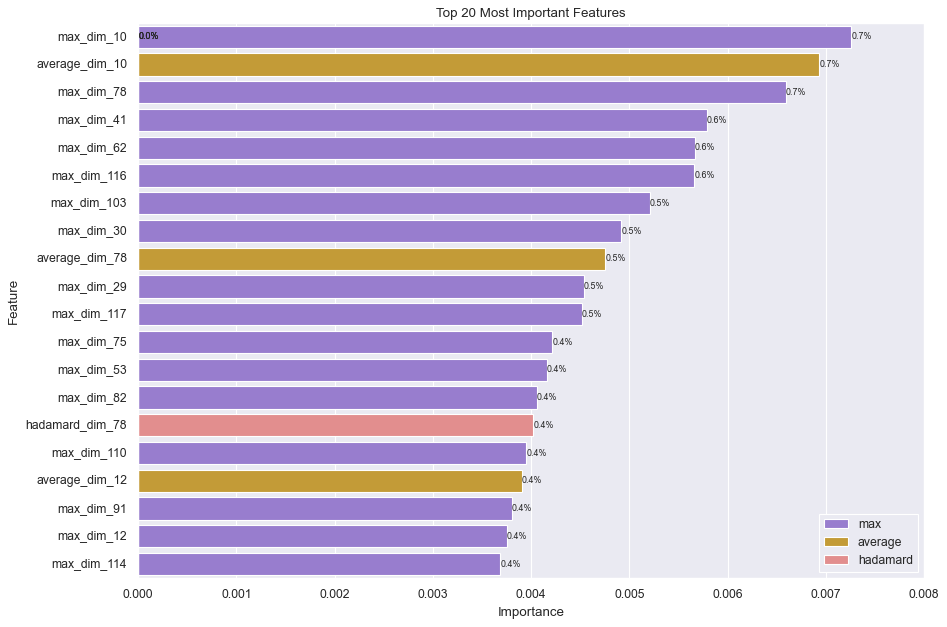


Feature Importance Summary by Operation:
max: 35.8%
average: 24.6%
hadamard: 21.2%
l1_distance: 18.4%


In [7]:
def load_and_plot_feature_importance(results_dir: str, top_n: int = 20):
    """Load and plot feature importance from saved results.
    
    Parameters:
    -----------
    results_dir: str
        Path to the results directory containing feature_importance.csv
    top_n: int
        Number of top features to display
    """
    sns.set_theme()
    # Load feature importance data
    feature_importance = pd.read_csv(Path(results_dir) / 'feature_importance.csv')
    
    # Sort by importance and get top N features
    top_features = feature_importance.nlargest(top_n, 'importance')
    
    # Create color palette based on operations
    operation_colors = {
        'hadamard': 'lightcoral',
        'l1_distance': 'lightseagreen',
        'average': 'goldenrod',
        'max': 'mediumpurple'
    }
    
    # Create plot
    plt.figure(figsize=(12, 8))
    bars = sns.barplot(
        data=top_features,
        x='importance',
        y='feature',
        hue='operation',
        palette=operation_colors
    )
    
    plt.title(f'Top {top_n} Most Important Features')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    
    # Add percentage to each bar
    total_importance = feature_importance['importance'].sum()
    for i, bar in enumerate(bars.patches):
        width = bar.get_width()
        percentage = (width / total_importance) * 100
        plt.text(width, bar.get_y() + bar.get_height()/2, 
                f'{percentage:.1f}%',
                ha='left', va='center', fontsize=8)
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()


load_and_plot_feature_importance(RESULTS_DIR)

def print_feature_importance_summary(results_dir: str):
    """Print summary of feature importance by operation"""
    feature_importance = pd.read_csv(Path(results_dir) / 'feature_importance.csv')
    
    print("\nFeature Importance Summary by Operation:")
    summary = feature_importance.groupby('operation')['importance'].sum().sort_values(ascending=False)
    total = summary.sum()
    
    for operation, importance in summary.items():
        percentage = (importance / total) * 100
        print(f"{operation}: {percentage:.1f}%")

# Print summary of importance by operation type
print_feature_importance_summary(RESULTS_DIR)

### Observations: 

Very interesting results. They suggest that
- element-wise max is the most informative operation for the relationship prediction, suggesting that if either the drug or the disease has a strong signal in a dimension then it's important for prediction
- looking at the importance scores distribution - model relies on a broad set of features rather than few predominant ones
- Hadamard product and L1 distance are less informative than simple max and average in the embedding space

### To improve:
Feature engineering can be improved here.
We could add
1. Node2Vec loss - based features, same featuers that Node2Vec used during training, dot products of the embeddings;
2. graph structural features: common neighbors, path length.


## 2. New Predictions (if available)

In [8]:
if has_predictions:
    # Distribution of predicted probabilities for new pairs
    plt.figure(figsize=(10, 6))
    sns.histplot(data=predictions_df, x='probability', bins=30)
    plt.title('Distribution of Predictions for New Drug-Disease Pairs')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Count')
    plt.show()
    
    # Show top 10 most confident predictions
    print("\nTop 10 Most Confident Predictions:")
    display(predictions_df.sort_values('probability', ascending=False).head(10))
    
    # Basic statistics of predictions
    print("\nPrediction Statistics:")
    print(predictions_df['probability'].describe())

## 3. Model Configuration

In [9]:
# Display model configuration
print("Model Configuration:")
for key, value in config.items():
    print(f"{key}: {value}")

Model Configuration:
nodes_file: data/Nodes.csv
edges_file: data/Edges.csv
ground_truth_file: data/Ground_Truth.csv
embeddings_file: drug_disease_embeddings.pkl
embedding_dim: 128
test_size: 0.2
timestamp: 20241029_204138
